<a href="https://colab.research.google.com/github/linguist89/Bookflix/blob/master/whisperx_alignment_english_danish_transcribed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ebooklib
!pip install -U lingtrain-aligner==0.4.3
!pip install razdel dateparser sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ebooklib: filename=EbookLib-0.18-py3-none-any.whl size=38791 sha256=b4e8726d6057a9ee4c2f2fb67017dda88a89258ee3e3127d6dc725a8e277ce7a
  Stored in directory: /root/.cache/pip/wheels/6d/c5/f9/c615f68c24f539a89184ea938cd630d5973d582af6ced69140
Successfully built ebooklib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.2/293.2 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━

In [2]:
import pandas as pd
import os
from tqdm import tqdm
import ebooklib
import numpy as np
import matplotlib.pyplot as plt
from ebooklib import epub
from bs4 import BeautifulSoup as bs
from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper

In [3]:
# Epub books
def extract_contents(book_filename):
    # Load epub book into paragraphs
    book = epub.read_epub(book_filename)
    all_paragraphs = []
    for token in book.get_items_of_type(ebooklib.ITEM_DOCUMENT):
        soup = bs(token.get_content())
        input_soup = [soup.text.strip()]
        all_paragraphs.append(input_soup)
    text = ' '.join([' '.join(text) for text in all_paragraphs])
    return text

In [4]:
text2 = extract_contents("The Little Prince - Antoine de Saint-Exupéry - EPUB.epub")
text2 = text2.split("\n")

/usr/local/lib/python3.8/dist-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')


In [5]:
df = pd.read_csv("den_lille_prins.csv")
df.drop('Unnamed: 0', inplace=True, axis=1)

In [14]:
text1 = [text['text'].strip() for text in eval(df.loc[0]['den_lille_prins.mp3'])['segments']]

In [16]:
# Convert time
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)

# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f}x + {:.2f}'.format(b, a))

    return a, b

# Creating the dictionary for the dictionary approach
import string

def create_words_dictionary():
    words = {}
    total_length = 0
    last_time_stamp = 0
    all_words = []
    starting_time_stamp = ("", 0)
    last_full_time_stamp = 0
    for i, row in df.transpose().sort_index().iterrows():
        start_range = eval(row[1])['word_segments'][0]['start'] + last_full_time_stamp
        end_range = eval(row[1])['word_segments'][-1]['end'] + last_full_time_stamp
        for j, segment in enumerate(eval(row[1])['word_segments']):
            text = segment['text'].strip()
            if starting_time_stamp[1] == 0:
                starting_time_stamp = text, start_range
            for p in string.punctuation:
                text = text.replace(p, "")
            start = segment['start'] + last_time_stamp
            end = segment['end'] + last_time_stamp
            all_words.append((text, start))
            if text.lower() in words.keys():
                words[text.lower()].append((start, end, start_range, end_range))
            else:
                words.update({text.lower(): [(start, end, start_range, end_range)]})
        last_time_stamp = end
        last_full_time_stamp = end_range
    return words, last_full_time_stamp, starting_time_stamp, all_words
words, last_full_time_stamp, starting_time_stamp, all_words = create_words_dictionary()

In [17]:
whisper_text = []
for i, row in df.transpose().sort_index().iterrows():
    for s in eval(row[1])['segments']:
        start = s['start']
        end = s['end']
        text = s['text'].strip()
        whisper_text.append(text)

best fit line:
y = 0.48x + 134.00
c: 134.00432154100918
m: 0.47599551751079283


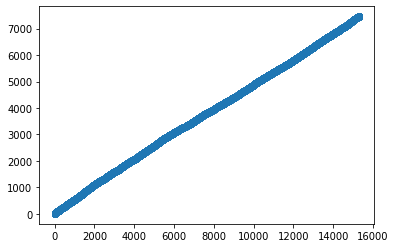

In [18]:
straight_line_type = "all_words"

total_words = [sentence.split() for sentence in whisper_text]
total_words = [i for j in total_words for i in j]
per_word_length = last_full_time_stamp/len(total_words)

if straight_line_type == "all_words":
    # Drawing straight-line graph
    xy_first_ten = []
    for i, ft in enumerate(all_words):
        xy_first_ten.append((i, ft[1]))
    first_ten_x = [xy[0] for xy in xy_first_ten]
    first_ten_y = [xy[1] for xy in xy_first_ten]

    c, m = best_fit(first_ten_x, first_ten_y)
    plt.scatter(first_ten_x, first_ten_y)
    yfit = [c + m * xi for xi in first_ten_x]
    print(f"c: {c}")
    print(f"m: {m}")
    plt.plot(first_ten_x, yfit)
elif straight_line_type == "length_word_count":
    # Calculate the line of best fit over the entire text and audio
    current_time_stamp = 0
    xy_line_best_fit = []
    for i, word in enumerate(total_words):
        xy_line_best_fit.append((i, current_time_stamp))
        current_time_stamp += per_word_length 
    x_line_best_fit = [xy[0] for xy in xy_line_best_fit]
    y_line_best_fit = [xy[1] for xy in xy_line_best_fit]

    c, m = best_fit(x_line_best_fit, y_line_best_fit)
    plt.scatter(x_line_best_fit, y_line_best_fit)
    yfit = [c + m * xi for xi in x_line_best_fit]
    print(f"c: {c}")
    print(f"m: {m}")
    plt.plot(x_line_best_fit, yfit)

In [19]:
# Align the texts
db_path = "full_cycle.db"

lang_from = "da"
lang_to = "en"

models = ["sentence_transformer_multilingual", "sentence_transformer_multilingual_labse"]
model_name = models[0]

text1_prepared = preprocessor.mark_paragraphs(text1)
text2_prepared = preprocessor.mark_paragraphs(text2)

splitted_from = splitter.split_by_sentences_wrapper(text1_prepared, lang_from, leave_marks=True)
splitted_to = splitter.split_by_sentences_wrapper(text2_prepared, lang_to, leave_marks=True)

if os.path.isfile(db_path):
    os.unlink(db_path)
    
aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)


aligner.align_db(db_path, \
                model_name, \
                batch_size=100, \
                window=40, \
                save_pic=False,
                embed_batch_size=10, \
                normalize_embeddings=True, \
                show_progress_bar=True
                )

batch: 0
Loading distiluse-base-multilingual-cased-v2 model from Internet.


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/610 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/531 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

batch: 1


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 2


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 3


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 4


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 5


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 6


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 7


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 8


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 9


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 10


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 11


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 12


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 13


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

batch: 14


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
conflicts_to_solve, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=6, batch_id=-1)

resolver.get_statistics(conflicts_to_solve)
resolver.get_statistics(rest)

conflicts to solve: 213
total conflicts: 249
('2:3', 63)
('3:3', 34)
('3:4', 18)
('2:1', 16)
('3:2', 14)
('4:5', 10)
('2:4', 8)
('3:5', 7)
('5:6', 7)
('4:4', 6)
('4:3', 6)
('5:5', 3)
('5:4', 3)
('6:6', 3)
('3:6', 3)
('5:3', 3)
('6:4', 2)
('6:5', 2)
('4:6', 1)
('6:3', 1)
('2:5', 1)
('3:1', 1)
('4:2', 1)
('4:7', 4)
('5:7', 4)
('7:9', 2)
('4:8', 2)
('7:7', 2)
('7:6', 2)
('6:8', 2)
('9:9', 1)
('2:7', 1)
('5:8', 1)
('2:0', 1)
('3:7', 1)
('8:5', 1)
('9:13', 1)
('7:8', 1)
('10:13', 1)
('15:22', 1)
('8:8', 1)
('4:9', 1)
('10:18', 1)
('7:10', 1)
('6:7', 1)
('6:9', 1)
('9:10', 1)
('11:11', 1)


conflicts to solve: 213
total conflicts: 249


100%|██████████| 213/213 [02:14<00:00,  1.58it/s]


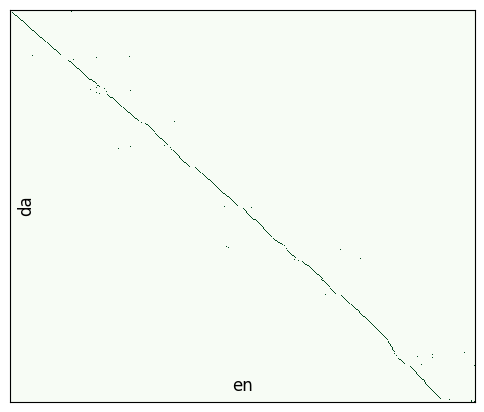

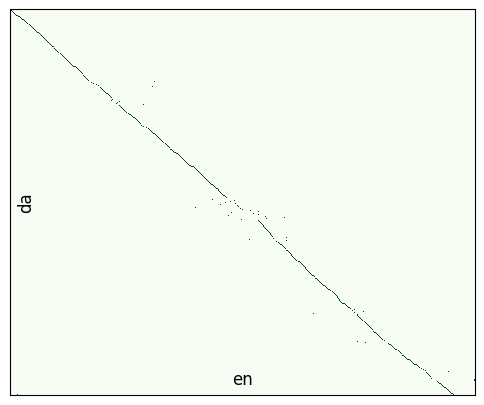

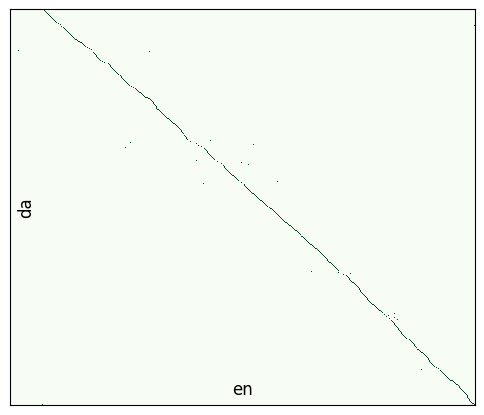

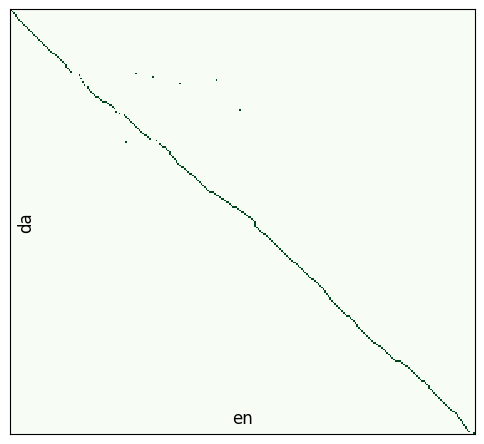

conflicts to solve: 31
total conflicts: 35


100%|██████████| 31/31 [01:20<00:00,  2.59s/it]


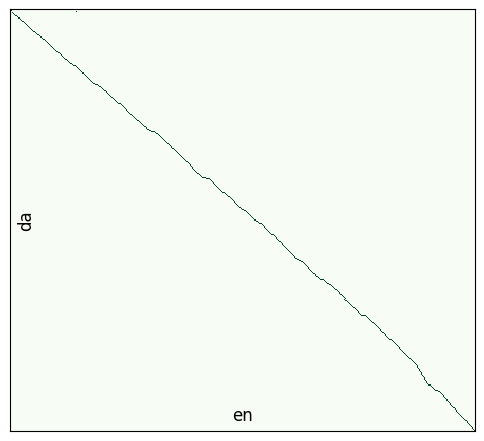

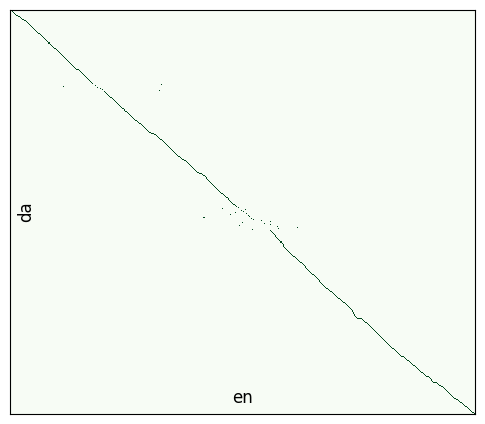

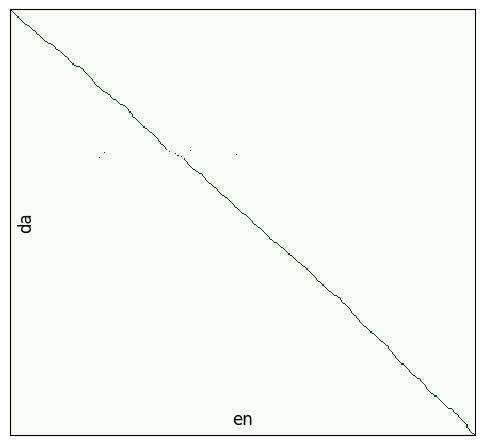

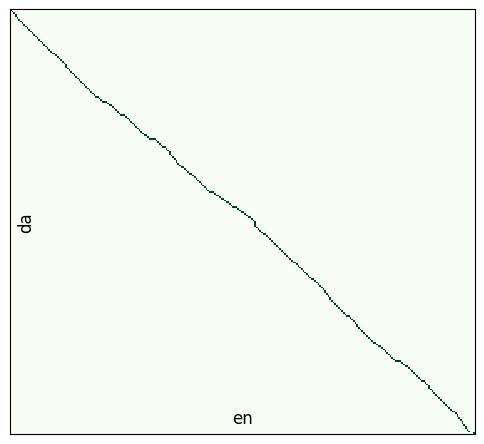

conflicts to solve: 2
total conflicts: 4


100%|██████████| 2/2 [00:37<00:00, 18.87s/it]


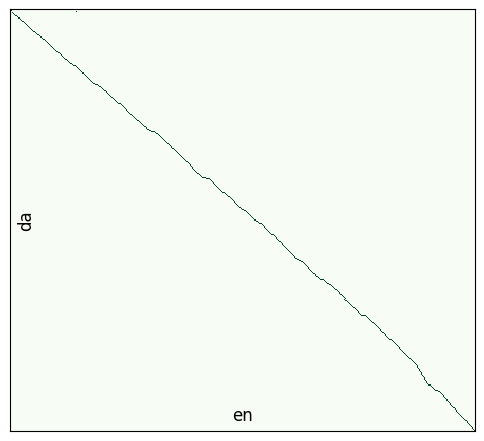

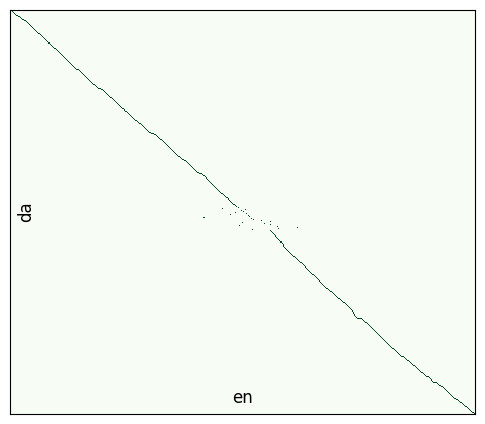

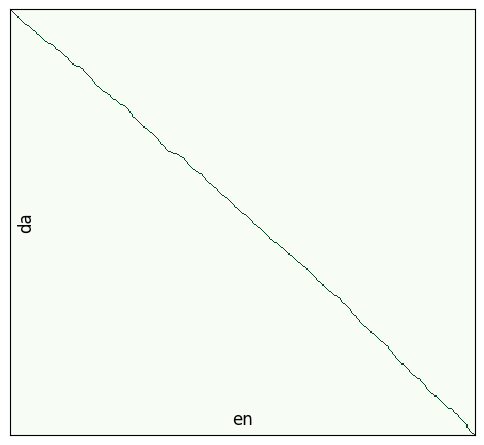

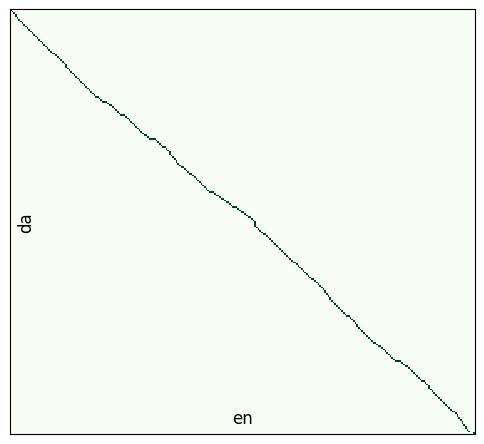

In [21]:
steps = 3
batch_id = -1 #выровнять все доступные батчи

for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2+i, max_conflicts_len=6*(i+1), batch_id=batch_id)
    resolver.resolve_all_conflicts(db_path, conflicts, model_name, show_logs=False)
    vis_helper.visualize_alignment_by_db(db_path, output_path="img_test1.png", lang_name_from=lang_from, lang_name_to=lang_to, batch_size=400, size=(600,600), plt_show=True)

    if len(rest) == 0: break

In [22]:
output_path = "result/the_little_prince.html"
paragraphs_from, paragraphs_to, meta = reader.get_paragraphs(db_path)

In [74]:
# Add timings

timings_extraction = {text['text'].strip(): (convert(text['start']), convert(text['end']))  for text in eval(df.loc[0]['den_lille_prins.mp3'])['segments']}

paragraphs_from_timings_add = []
for i, pf in enumerate(paragraphs_from):
    timing = timings_extraction.get(pf[0], "Unknown -> Unknown")
    if "Unknown" in timing:
        paragraphs_from_timings_add.append([f"{pf[0]} == {timing}"])
    else:
        paragraphs_from_timings_add.append([f"{pf[0]} == {timing[0]} -> {timing[1]}"])

In [75]:
reader.create_book(paragraphs_from_timings_add, paragraphs_to, meta, output_path, template="simple")

In [76]:
print(paragraphs_from[2][0])
print(paragraphs_from_timings_add[2][0])

Denne voksne forstår alt, selv bøger for børn.
Denne voksne forstår alt, selv bøger for børn. == 0:00:36 -> 0:00:41


In [52]:
danish_text = paragraphs_from_timings_add
english_text = paragraphs_to[2][0]
print(danish_text)
print(english_text)

["['Den lille prins af Antoine de Saint-Exupery En lydbog for Carlsen indtalt af Fritz Helmut Til Leon Wirt Jeg må bede jer børn undskyld at denne bog er tilegnet en voksen Men jeg har en virkelig god undskyldning Den voksne, der er tale om, er den bedste ven, jeg nogensinde har haft.'] == ? ->  ", "['Jeg har også en anden undskyldning.'] == 0:00:32 -> 0:00:34", "['Denne voksne forstår alt, selv bøger for børn.'] == 0:00:36 -> 0:00:41", "['Og jeg har endnu en undskyldning.'] == 0:00:43 -> 0:00:44", "['Han bor i Frankrig, hvor han sulter og fryser.'] == 0:00:46 -> 0:00:48", "['Han trænger virkelig til tryst.'] == 0:00:50 -> 0:00:51", "['Hvis alle disse undskyldninger ikke slår til, skal jeg gerne dedikere bogen til denne voksne som barn.'] == 0:00:54 -> 0:01:03", "['Alle voksne har engang været børn, men det er ikke ret mange af dem, der kan huske det.'] == 0:01:05 -> 0:01:11", "['Min dedikation kommer altså i stedet for til at lyde til Leon Wirt.'] == 0:01:13 -> 0:01:20", "['Dengang ha